# Audio Feature Analysis SIM 2 - Detecting Pigs and the Swedish Chef

**Authors: Sakka Mahmoud Abdussalem, Kravchenko Oleksandra**

This notebook contains the audio feature analysis for the Similarity Modeling 2 project. The objective is to detect the presence of Pigs or Swedish Chef (Cook) in a scene using audio features.

## Timesheets
**Oleksandra's timesheet**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>10.01.25</td>
    <td>Set up this notebook and research audio features to try, extract MFCC</td>
    <td>2 hrs</td>
  </tr>
  <tr>
    <td>14.01.25</td>
    <td>Write functions for log mel features, probabilistic YIN, debug code</td>
    <td>4 hrs</td>
  </tr>
    <tr>
    <td>18.01.25</td>
    <td>Train and evaluate models</td>
    <td>3 hrs</td>
  </tr>
    <tr>
    <td>19.01.25</td>
    <td>Write documentation and analyse results</td>
    <td>3 hrs</td>
  </tr>
</tbody>
</table>

**Mahmoud's timesheet:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>xx.xx.xx</td>
    <td>done something</td>
    <td>how long</td>
  </tr>
</tbody>
</table>


## Required packages

In [41]:
import librosa
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scripts.load_data import check_and_load
from scripts.sim2_extract_audio_features import extract_mfcc, extract_log_mel_spectrogram, extract_yin
from scripts.nested_cv import partition_feature_df, evaluate_model, nested_cross_validation
from scripts.evaluation_holdout import evaluate_model_ho
import pickle
import matplotlib.pyplot as plt

In [3]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


# Feature engineering

The extracted audio signals are slightly shorter than the original video, making it essential to align their duration to ensure that the audio frames correspond to the frames in the annotations (`ground_truth`). Thus, padding—specifically zero-padding—is applied to extend the shorter audio signals to the required length by filling gaps at the end of the audio signals without altering their original structure.
After padding, audio signals are normalized to a common scale. This step adjusts the amplitude values to a standardized range, enhancing the comparability of features across samples and mitigating the effects of volume differences.

We try out 3 different features:
- **MFCC**: we use Mel-Frequency Cepstral Coefficients (MFCC) primarly to capture the timbre of the characters' voice. Each character's voice has unique characteristics like tone and resonance. MFCCs are based on mel frequencies, which adjust for how humans perceive sound frequencies, helping distinguish different voices based on their spectral shapes. 
- **Log Mel Spectograms**: provides a time-frequency representation of audio, encodes detailed frequency and intensity information, such as pitch patterns and voice texture. These patterns aim to capture the characters' distinctive speaking style and delivery.
- **Probabilistic YIN**: estimates the pitch based on fundamental frequency.Different characters often speak at varying pitches. This feature emphasizes pitch variations, which are essential for identifying characters with distinct vocal range.

The characters in the Muppet Show mostly have very distinct speech patterns, so with a range of methods we hope to capture the differences between them for classification. It is important to note that MFCC essentially are based mel spectograms, so having another similar feature may either be redundant or introduce more granularity to represent the characters even more efficiently. 

## MFCC
We extract the MFCC features using the librosa library. We use 20 features, which is within the standard range for speech recognition. These feature describe the the overall shape of the spectral envelope. This representation should be effective for distinguishing different speakers or characters, as the spectral envelope is closely tied to the unique vocal characteristics, such as timbre and resonance, which vary between different voices. By focusing on 20 coefficients, we strike a balance between capturing sufficient detail and maintaining computational efficiency, ensuring that the extracted features are both informative and manageable for classification tasks.

The first few MFCCs typically capture the most significant spectral characteristics, such as overall energy and broad spectral shape, while higher-order coefficients represent finer details like texture and formant structures. These nuances are essential for identifying subtle differences in speech patterns, making MFCCs a reliable choice for speech-based character classification.

In [38]:
# extract MFCCs 
extract = False

if extract == True:
    mfcc_features  = extract_mfcc(audio_data)
else: 
    print("Set extract to True if you want to extract the features")

Set extract to True if you want to extract the features


## Log Mel spectrogram

In [5]:
log_mel_features = extract_log_mel_spectrogram(audio_data)

## Probabilistic YIN pitch extraction

In [ ]:
extract = False

if extract == True:
    yin_extracted = extract_yin(audio_data)
        
    out = pd.DataFrame()
    video_id_mapper = {"Muppets-02-01-01.wav":0, "Muppets-03-04-03.wav":2, "Muppets-02-04-04.wav":1}
    
    for audio_entry in audio_data:
        audio_file = audio_entry.get('audio_file', 'Unknown file')
        video_id = video_id_mapper.get(audio_file)
        
        df = pd.DataFrame(yin_extracted[audio_file]).T
        df = df.rename(columns={0:"yin", 1:"voiced_flag", 2:"voiced_prob"})
        df = df.reset_index(names="frame_idx")
        df["video_idx"] = video_id
        
        out = pd.concat([out, df], axis=0)
        
    return out

    output_yin.to_csv("../model_data/features/yin_features.csv", index=False)
    
else: 
    print("Set extract to True to extract features")

Processing audio entries:   0%|          | 0/3 [00:00<?, ?it/s]

Processing audio entries: 100%|██████████| 3/3 [17:40<00:00, 353.57s/it]


## Extract features

In [20]:
output_yin = pd.read_csv("../model_data/features/yin_features.csv")
output_yin = output_yin.fillna(0)
output_yin = output_yin[["yin", "video_id", "frame_id"]]
output_yin = output_yin.rename(columns={"frame_id":"frame_idx", "video_id":"video_idx"})

In [34]:
# Initialize the final list to hold feature rows
extracted_features_df = []

# Loop through the data for each video
for video_idx, (audio_entry, mfcc, log_mel) in enumerate(
        zip(audio_data, mfcc_features, log_mel_features)):
    
    num_frames = mfcc.shape[1]-2  # -2 accounts for edge frames in MFCC
    print(num_frames)

    for frame_idx in range(num_frames):
        feature_row = {
            "video_idx": video_idx,
            "frame_idx": frame_idx
        }

        # Add MFCC features
        mfcc_values = {f"mfcc_{i+1}": mfcc[i, frame_idx] for i in range(mfcc.shape[0])}
        feature_row.update(mfcc_values)
        
        # Add Log Mel features
        log_mel_values = {f"log_mel_{i+1}": log_mel[i, frame_idx] for i in range(log_mel.shape[0])}
        feature_row.update(log_mel_values)

        # Append the row to the list
        extracted_features_df.append(feature_row)

# Convert the list of features into a DataFrame
extracted_features_df = pd.DataFrame(extracted_features_df) 
extracted_features_df = pd.merge(extracted_features_df, output_yin, on = ["frame_idx", "video_idx"], how="left")

# Display the shape of the combined DataFrame
print(extracted_features_df.shape)

38681
38498
38706
(115885, 63)


In [32]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  # Map video filename to its index
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  # Use mapped video index
            'frame_idx': row['Frame_number'],  # Assuming Frame_number exists
            #'Pigs': row['Pigs'],  # Assuming Pigs is a column in the annotation
            #'Cook': row['Cook']  # Assuming this column exists
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 2)

In [35]:
merged = pd.merge(ground_truth_df, extracted_features_df, on = ["frame_idx", "video_idx"], how="left")

In [36]:
merged.to_csv("../model_data/features/sim2_audio_features.csv")

In [44]:
output_yin = output_yin.fillna(0)
output_yin = output_yin[["yin", "video_id", "frame_id"]]

In [63]:
extracted_features_df["yin"] = extracted_features_df["yin"].fillna(0)

# Pigs classification

In [75]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx, 
            'frame_idx': row['Frame_number'], 
            'Audio_Pigs': row['Audio_Pigs'], 
            'Audio_Cook': row['Audio_Cook']  
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 4)

In [86]:
feature_df = pd.merge(extracted_features_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='inner')

In [80]:
feature_df.columns

Index(['video_idx', 'frame_idx', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'log_mel_1', 'log_mel_2', 'log_mel_3',
       'log_mel_4', 'log_mel_5', 'log_mel_6', 'log_mel_7', 'log_mel_8',
       'log_mel_9', 'log_mel_10', 'log_mel_11', 'log_mel_12', 'log_mel_13',
       'log_mel_14', 'log_mel_15', 'log_mel_16', 'log_mel_17', 'log_mel_18',
       'log_mel_19', 'log_mel_20', 'log_mel_21', 'log_mel_22', 'log_mel_23',
       'log_mel_24', 'log_mel_25', 'log_mel_26', 'log_mel_27', 'log_mel_28',
       'log_mel_29', 'log_mel_30', 'log_mel_31', 'log_mel_32', 'log_mel_33',
       'log_mel_34', 'log_mel_35', 'log_mel_36', 'log_mel_37', 'log_mel_38',
       'log_mel_39', 'log_mel_40', 'yin', 'Audio_Pigs', 'Audio_Cook', 'fold'],
      dtype='object')

In [87]:
grp_by = ['Audio_Pigs', 'Audio_Cook']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

output_path_feature = "../model_data/features/sim2_audio_feature_df.csv"
feature_df.to_csv(output_path_feature, index=False)

feature_df.shape

(115677, 66)

In [88]:
print(split_overview)

   video_idx fold  Audio_Pigs  Audio_Cook
0          0  0-A         311           0
1          0  0-B           0        1157
2          1  1-A         950           0
3          1  1-B        1906           0
4          2  2-A         742          95
5          2  2-B        2267         189


## Naive Bayes

In [89]:
# Define parameter grid
param_grid = {}

feature_df_pigs = feature_df.loc[feature_df["fold"].isin(["0-A", "1-A", "1-B", "2-A", "2-B"])]

target_col = 'Audio_Pigs'
train_cols = feature_df_pigs.drop(["video_idx", "frame_idx", "Audio_Pigs", "Audio_Cook", "fold"], axis=1).columns.to_list()

results_nb_pigs, summary_nb_pigs, best_model_nb_pigs = nested_cross_validation(
    feature_df_pigs, 
    train_cols, 
    target_col, 
    GaussianNB, 
    param_grid, 
    num_cores=10
)

with open('../model_data/results/pigs_nb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_nb_pigs,
        'summary_pigs': summary_nb_pigs,
        'best_model_pigs': best_model_nb_pigs
    }, f)


Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.28621424223980524, 'precision': np.float64(0.9774307604698117), 'recall': np.float64(0.28621424223980524), 'f1': np.float64(0.42664209862974223), 'roc_auc': np.float64(0.6012108623842266)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.6023632030021806, 'precision': np.float64(0.9106500911017147), 'recall': np.float64(0.6023632030021806), 'f1': np.float64(0.7139578913563724), 'roc_auc': np.float64(0.5391402957283987)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.46253794131742904, 'precision': np.float64(0.8740427054388463), 'recall': np.float64(0.46253794131742904), 'f1': np.float64(0.5494540812111479), 'roc_auc': np.float64(0.6688413702787611)}
Metrics for Fold 2-A: {'outer_fold': '2-A', 'accuracy': 0.6241766158913133, 'precision': np.float64(0.9523052090637315), 'recall': np.float64(0.6241766158913133), 'f1': np.float64(0.7359179041589231), 'roc_auc': np.float64(0.7716925969030818)}
Metrics for Fold 2-

## Random Forest

In [90]:

# Define parameter grid
param_grid = {}

feature_df_pigs = feature_df.loc[feature_df["fold"].isin(["0-A", "1-A", "1-B", "2-A", "2-B"])]

target_col = 'Audio_Pigs'
train_cols = feature_df_pigs.drop(["video_idx", "frame_idx", "Audio_Pigs", "Audio_Cook", "fold"], axis=1).columns.to_list()

results_rf_pigs, summary_rf_pigs, best_model_rf_pigs = nested_cross_validation(
    feature_df_pigs, 
    train_cols, 
    target_col, 
    RandomForestClassifier, 
    param_grid, 
    num_cores=10
)

## Save Vars
with open('../model_data/results/pigs_rf_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_rf_pigs,
        'summary_pigs': summary_rf_pigs,
        'best_model_pigs': best_model_rf_pigs
    }, f)


Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.9818421586528707, 'precision': np.float64(0.970813310264519), 'recall': np.float64(0.9818421586528707), 'f1': np.float64(0.9757988422802982), 'roc_auc': np.float64(0.7164211663550101)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.9493889142451443, 'precision': np.float64(0.9139073869282319), 'recall': np.float64(0.9493889142451443), 'f1': np.float64(0.9281363281558406), 'roc_auc': np.float64(0.4943744023599946)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.8991426593535332, 'precision': np.float64(0.8967107654038354), 'recall': np.float64(0.8991426593535332), 'f1': np.float64(0.8522281401246755), 'roc_auc': np.float64(0.660221468710543)}
Metrics for Fold 2-A: {'outer_fold': '2-A', 'accuracy': 0.961300946891725, 'precision': np.float64(0.9426851824972592), 'recall': np.float64(0.961300946891725), 'f1': np.float64(0.9455429422191554), 'roc_auc': np.float64(0.779559279722065)}
Metrics for Fold 2-B: {'outer

# Cook classification

In [102]:
split_overview

,video_idx,fold,Audio_Pigs,Audio_Cook
0,0,0-A,311,0
1,0,0-B,0,1157
2,1,1-A,950,0
3,1,1-B,1906,0
4,2,2-A,742,95
5,2,2-B,2267,189


In [125]:
feature_df_cook = feature_df.loc[feature_df["fold"].isin(["0-B", "2-A", "2-B"])].drop(["Audio_Pigs"], axis=1)

## Naive Bayes

In [129]:
X_train_cook = feature_df_cook.loc[feature_df_cook["fold"] == "0-B"].drop(["Audio_Cook", "fold", "video_idx", "frame_idx"], axis=1)
y_train_cook = feature_df_cook.loc[feature_df_cook["fold"] == "0-B"]["Audio_Cook"]

X_test_cook = feature_df_cook.loc[feature_df_cook["fold"] != "0-B"].drop(["Audio_Cook", "fold", "video_idx", "frame_idx"], axis=1)
y_test_cook = feature_df_cook.loc[feature_df_cook["fold"] != "0-B"]["Audio_Cook"]

In [131]:
nb = GaussianNB()
nb.fit(X_train_cook, y_train_cook)
y_pred_cook_nb = nb.predict(X_test_cook)

metrics_cook_nb = {
    'accuracy': accuracy_score(y_test_cook, y_pred_cook_nb),
    'precision': precision_score(y_test_cook, y_pred_cook_nb, average='binary', zero_division=0),
    'recall': recall_score(y_test_cook, y_pred_cook_nb, average='binary', zero_division=0),
    'f1': f1_score(y_test_cook, y_pred_cook_nb, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_cook_nb).to_csv("../model_data/results/y_pred_cook_nb.csv")

print("Evaluation Metrics:")
for metric, value in metrics_cook_nb.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.7767
precision: 0.0107
recall: 0.3204
f1: 0.0207


Evaluation Metrics for Cook Naive Bayes:
Accuracy: 0.7767
Precision: 0.9863
Recall: 0.7767
F1 Score: 0.8677


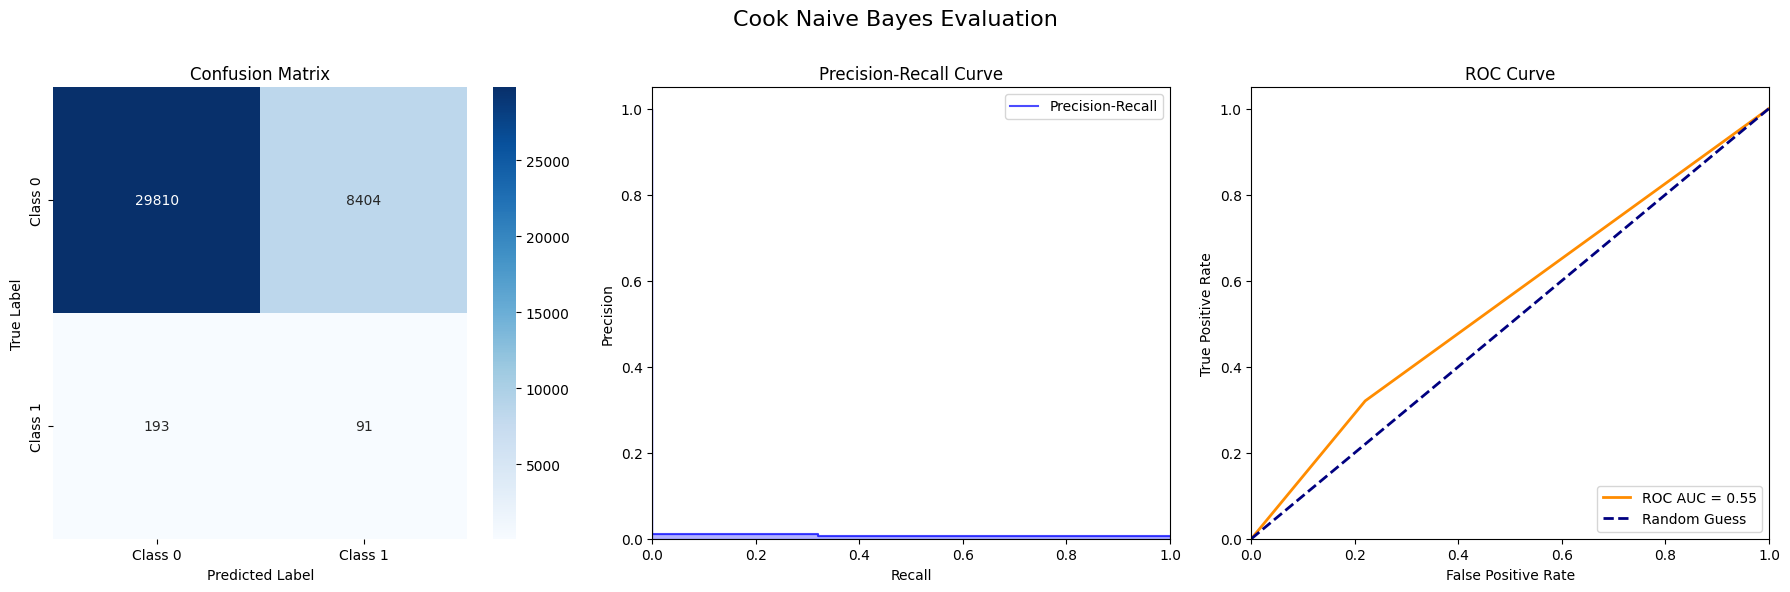

In [134]:
evaluate_model_ho(y_test_cook, y_pred_cook_nb, title = "Cook Naive Bayes")

## Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_cook, y_train_cook)
y_pred_cook_rf = rf.predict(X_test_cook)

metrics_cook_rf = {
    'accuracy': accuracy_score(y_test_cook, y_pred_cook_rf),
    'precision': precision_score(y_test_cook, y_pred_cook_rf, average='binary', zero_division=0),
    'recall': recall_score(y_test_cook, y_pred_cook_rf, average='binary', zero_division=0),
    'f1': f1_score(y_test_cook, y_pred_cook_rf, average='binary', zero_division=0)
}

pd.DataFrame(y_pred_cook_rf).to_csv("../model_data/results/y_pred_cook_rf.csv")

print("Evaluation Metrics:")
for metric, value in metrics_cook_rf.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
accuracy: 0.9918
precision: 0.0303
recall: 0.0035
f1: 0.0063


In [110]:
evaluate_model_ho(y_test_cook, y_pred_cook_rf, title = "Cook Random Forest")

NameError: name 'evaluate_model_ho' is not defined

# XGBoost - Pigs

HIER Text warum wir Cook nicht machen

In [1]:
import pandas as pd
import numpy as np
from scripts.nested_cv import partition_feature_df
from scripts.nested_cv import evaluate_model, nested_cross_validation, ncv_xgb_gpu
from scripts.load_data import check_and_load
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4070 Ti SUPER


In [2]:
audio_features_path = "../model_vars/sim2_audio/sim2_audio_features.csv"
audio_feature_df = pd.read_csv(audio_features_path)
audio_feature_df.shape

(115885, 64)

In [3]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data/audio"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


In [4]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  # Map video filename to its index
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  # Use mapped video index
            'frame_idx': row['Frame_number'],  
            'Audio_Pigs': row['Audio_Pigs'],  
            'Audio_Cook': row['Audio_Cook']
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 4)

In [5]:
# Merge features with ground truth
feature_df = pd.merge(audio_feature_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='inner')
feature_df.shape

(115885, 66)

In [6]:
# split_points = {
#     0: 19716,  # Video 0
#     1: 19719,  # Video 1
#     2: 19432, # Video 2 
# }

# Assuming feature_df is the dataframe containing video_idx and frame_idx columns
grp_by = ['Audio_Pigs', 'Audio_Cook']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

feature_df.shape

print(split_overview)

feature_df['fold'].unique() # ACHTUNG manche fehlen in den Splits!

   video_idx fold  Audio_Pigs  Audio_Cook
0          0  0-A         311           0
1          0  0-B           0        1157
2          1  1-A         950           0
3          1  1-B        1906           0
4          2  2-A         742          95
5          2  2-B        2267         189


array(['0-A', '0-B', '1-A', '1-B', '2-A', '2-B'], dtype=object)

In [7]:
# Select only numeric columns
numeric_df = feature_df.select_dtypes(include=[np.number])


print("NaN in any feature:", feature_df.isnull().values.any())
# Check for infinite values in numeric columns
print("Inf in any numeric feature:", np.isinf(numeric_df.values).any())

# Optionally, find rows with infinite values
rows_with_inf = numeric_df[np.isinf(numeric_df).any(axis=1)].index.tolist()
print("Rows with Inf values:", rows_with_inf)

NaN in any feature: True
Inf in any numeric feature: False
Rows with Inf values: []


In [14]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

feature_df_pigs = feature_df[feature_df['fold'] != "0-B"]
feature_df_pigs.shape

train_cols = feature_df_pigs.drop(["Unnamed: 0","video_idx", "frame_idx", "Audio_Pigs", "Audio_Cook", "fold"], axis=1).columns
# train_cols.to_series().to_csv('../model_vars/sim2_audio/train_cols.csv', index=False, header=False)



target_col='Audio_Pigs'
results_xgb_pigs, summary_xgb_pigs, best_models_xgb_pigs = ncv_xgb_gpu(
    feature_df=feature_df_pigs,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)


## Save Vars
import pickle
with open('../model_vars/sim2_audio/pigs_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_xgb_pigs,
        'summary_pigs': summary_xgb_pigs,
        'best_model_pigs': best_models_xgb_pigs
    }, f)

Outer Fold: 0-A
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.9349743837170232, 'precision': 0.33811965811965816, 'recall': 0.013783930201509476, 'f1': 0.0219598194223057, 'roc_auc': 0.683531783642155}


## Evaluation

In [28]:
# load if necessary

import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim2_audio/pigs_xgb_results.pkl', 'rb') as f:
    pigs_data = pickle.load(f)
    results_xgb_pigs = pigs_data['results_pigs']
    summary_xgb_pigs = pigs_data['summary_pigs']
    best_models_xgb_pigs = pigs_data['best_model_pigs']


In [29]:
results_xgb_pigs

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.979053,0.107692,0.045016,0.063492,0.771513
1,1-A,0.951823,NaN,0.000000,0.000000,0.448748
2,1-B,0.899458,0.200000,0.000525,0.001047,0.695093
3,2-A,0.961816,NaN,0.000000,0.000000,0.801067
4,2-B,0.882723,0.706667,0.023379,0.045260,0.701238


Fold 2-A Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18690
           1       0.00      0.00      0.00       742

    accuracy                           0.96     19432
   macro avg       0.48      0.50      0.49     19432
weighted avg       0.93      0.96      0.94     19432



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


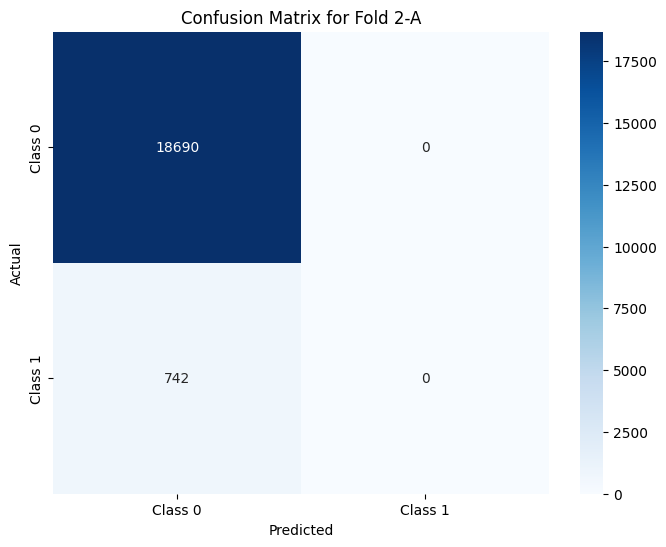

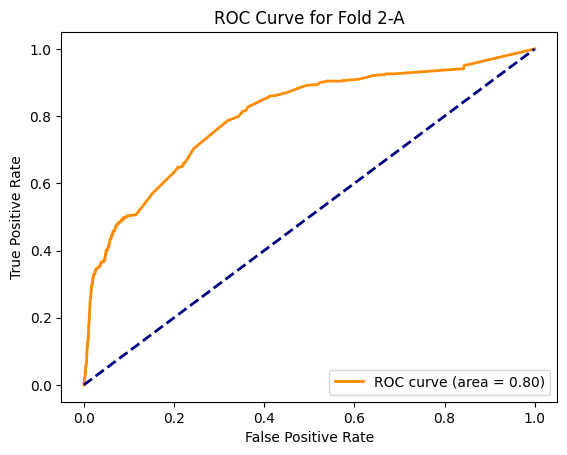

In [30]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Audio_Pigs', results_xgb_pigs, spec_fold= "best")

Fold 1-A Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     18769
           1       0.00      0.00      0.00       950

    accuracy                           0.95     19719
   macro avg       0.48      0.50      0.49     19719
weighted avg       0.91      0.95      0.93     19719



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


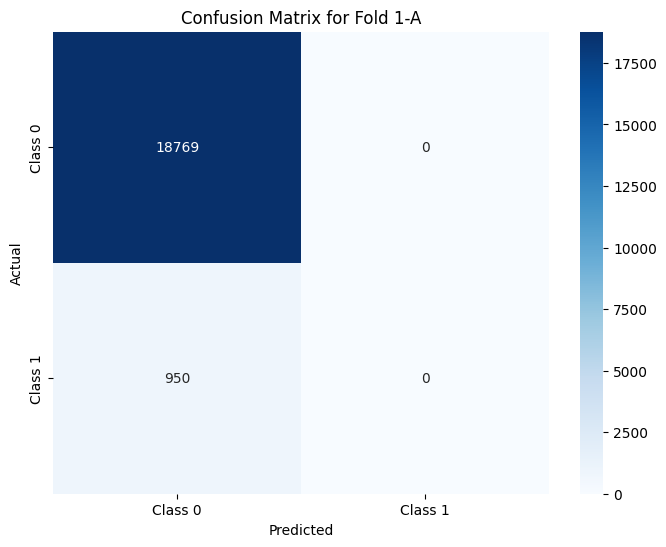

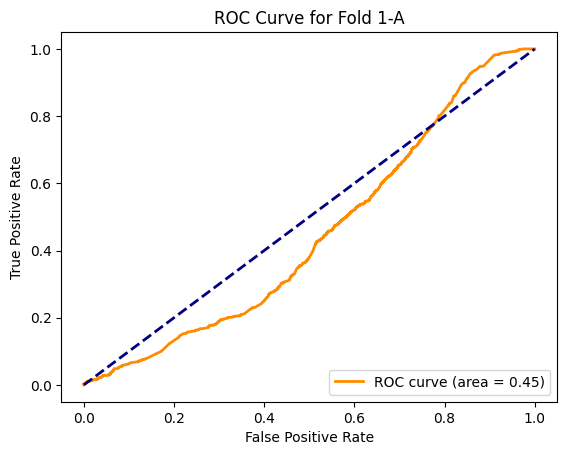

In [31]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Audio_Pigs', results_xgb_pigs, spec_fold= "worst")

Bester Fold

In [32]:
results_xgb_pigs

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.979053,0.107692,0.045016,0.063492,0.771513
1,1-A,0.951823,NaN,0.000000,0.000000,0.448748
2,1-B,0.899458,0.200000,0.000525,0.001047,0.695093
3,2-A,0.961816,NaN,0.000000,0.000000,0.801067
4,2-B,0.882723,0.706667,0.023379,0.045260,0.701238


Actual Best Fold (Prec and Recall)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.94     16799
     Class 1       0.71      0.02      0.05      2267

    accuracy                           0.88     19066
   macro avg       0.80      0.51      0.49     19066
weighted avg       0.86      0.88      0.83     19066

Confusion Matrix:
[[16777    22]
 [ 2214    53]]


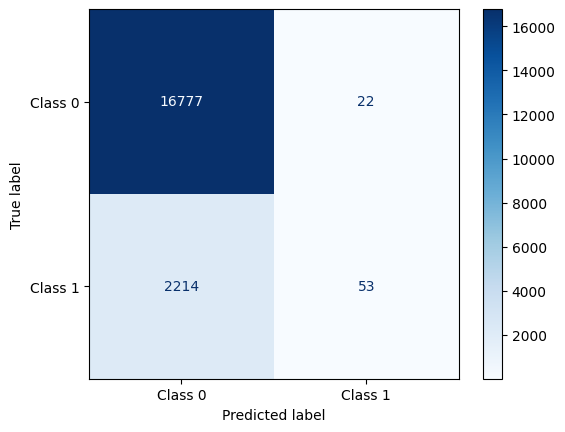

In [33]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
fold = '2-B'

fold_data = feature_df[feature_df['fold'] == fold]
X_fold = fold_data[train_cols].values  # Features for the fold
y_fold = fold_data['Audio_Pigs'].values  # True labels for the fold
X_fold_dmatrix = xgb.DMatrix(X_fold)

y_pred = (best_models_xgb_pigs[fold].predict(X_fold_dmatrix) > 0.5).astype(int)

report = classification_report(y_fold, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

cm = confusion_matrix(y_fold, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')


## Feature Importance

<Figure size 1200x800 with 0 Axes>

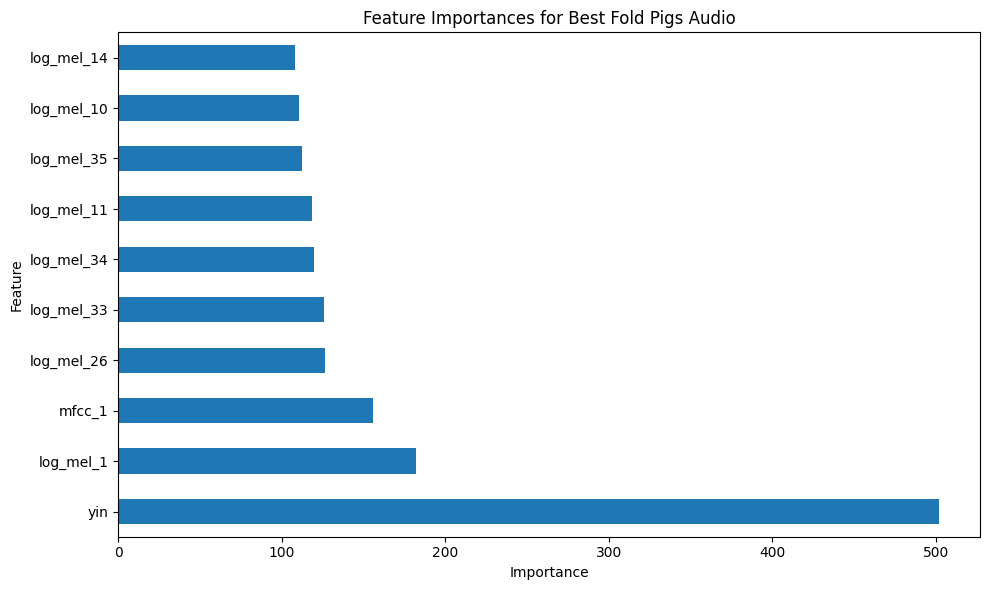

In [19]:
from scripts.nested_cv import plot_feature_importances 

# Pigs
plot_feature_importances(best_models_xgb_pigs, feature_df, train_cols, results_xgb_pigs, name= "Pigs Audio", n= 10)


## XGBoost Cook 
We did not do XGBoost evaluation for the Swedish Chef because of the lack of observations.